# Your mission

You started working on the Ecowatt project at RTE. In order to avoid possible shortage, one must plan for peaks in national electricity. You manager Mark is going on holidays for a week. You will be sole responsible for forecasting the weekly demand, while he is absent.

In order to prevent electricity shortage, you must accurately forecast the demand 7 days ahead, on an hourly basis.

Your mission is to train an accurate predictive model with the lowest root mean squared error (RMSE). Mark is a very technical guy, he likes to understand all technical details and would like you to compare the performances of classical models and neural-net based models.


Your **target variable** is the consommation_totale

**Data source** : https://data.enedis.fr/pages/accueil/

On Colab go to "Execute" -> "Modify Execution Type" -> select GPU.

# Import

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
from datetime import datetime
from typing import Tuple, List
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Create the model

In [4]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
    
        # use the last hidden state as the input to the fully connected layer
        out = self.fc(hidden[-1])
    
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        return hidden


## Prepare the data

In [5]:
from typing import Tuple
import numpy as np

def create_sequences(data: np.ndarray, sequence_length: int, pred_len: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """Create sequences from data with a given sequence (input) length and a given prediction (output) length

    Args:
        data (np.ndarray): data to create sequences from
        sequence_length (int): length of the input sequence
        pred_len (int, optional): length of the output sequence. Defaults to 1.

    Returns:
        Tuple[np.ndarray, np.ndarray]: input sequences
    """
    x = []
    y = []
    for i in range(len(data)-sequence_length-pred_len+1):
        x.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+pred_len])
    return np.array(x), np.array(y)

In [8]:
def preprocess_data(file_path, sequence_length=186, output_seq_len=1, split_ratio=0.8, batch_size=32):
    # Load the dataset
    df = read_data(file_path)
    data = df['consommation_totale'].values.reshape(-1, 1)
    
    # Normalize the 'consommation_totale' data with MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data)
    
    x, y = create_sequences(data, sequence_length, output_seq_len)  # pass output_seq_len here
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-split_ratio, shuffle=False)

    # Convert to Tensors and create data loaders
    train_data = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    test_data = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
    
    return train_loader, test_loader, scaler

In [9]:
def read_data_temp(data_path : str = "data/bilan-electrique.csv") -> pd.DataFrame:
    df = pd.read_csv(data_path)
    df['horodate'] = pd.to_datetime(df['horodate']) # Convert 'horodate' column to datetime
    df = df.set_index('horodate') # Set 'horodate' as the index
    # Filter rows where the value of column "Mois" is 6
    #df = df[df['mois'] == 6]
    hourly_avg = df.groupby(pd.Grouper(freq='H'))['Température normale lissée (°C)'].mean().reset_index(name='Température normale lissée (°C)')
    return hourly_avg

In [10]:
def preprocess_data_temp(file_path, sequence_length=186, output_seq_len=1, split_ratio=0.8, batch_size=32):
    # Load the dataset
    df = read_data(file_path)
    data = df['Température normale lissée (°C)'].values.reshape(-1, 1)
    
    # Normalize the 'Température normale lissée (°C)' data with MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data)
    
    x, y = create_sequences(data, sequence_length, output_seq_len)  # pass output_seq_len here
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-split_ratio, shuffle=False)

    # Convert to Tensors and create data loaders
    train_data = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    test_data = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
    
    return train_loader, test_loader, scaler

## Train the model

In [11]:
def train_model(model, train_loader, test_loader, num_epochs, learning_rate, patience=25):
    """Train the model and print the loss for each epoch

    Args:
        model: the model to train
        train_loader: the training data loader
        test_loader: the testing data loader
        num_epochs: the number of epochs to train
        learning_rate: the learning rate
        patience: the number of epochs to wait before early stopping
    """
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) # clip gradients to prevent exploding gradient problem 
    criterion = torch.nn.MSELoss() # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer (backward pass)
    
    train_loss_list = []
    test_loss_list = []

    best_loss = float('inf')
    no_improve_epoch = 0

    for epoch in tqdm.tqdm(range(num_epochs), desc='Training the model', unit='epoch', total=num_epochs):
        
        ## Training
        train_loss = 0
        for inputs, targets in train_loader: # for each training step
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs) # forward pass
            targets = targets[:,0,:]
            loss = criterion(output, targets)

            optimizer.zero_grad() # clear the gradients
            loss.backward() # backward pass
            optimizer.step() # optimize the weights

            train_loss += loss.item() 
            
        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)
        
        ## Testing 
        test_loss = 0
        with torch.no_grad(): 
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                output = model(inputs)
                targets = targets[:,0,:]
                loss = criterion(output, targets)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_loss_list.append(test_loss)

        #print('Epoch [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}'
        #      .format(epoch+1, num_epochs, train_loss, test_loss))

        # check for early stopping (prevent overfitting)
        if test_loss < best_loss:
            best_loss = test_loss
            no_improve_epoch = 0
        else:
            no_improve_epoch += 1
            if no_improve_epoch == patience:
                print('Early stopping')
                break

    # Plot training and testing loss
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(test_loss_list, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Time')
    plt.legend()
    plt.show()

    return model


Training the model:  11%|█         | 108/1000 [06:46<55:59,  3.77s/epoch]

Early stopping


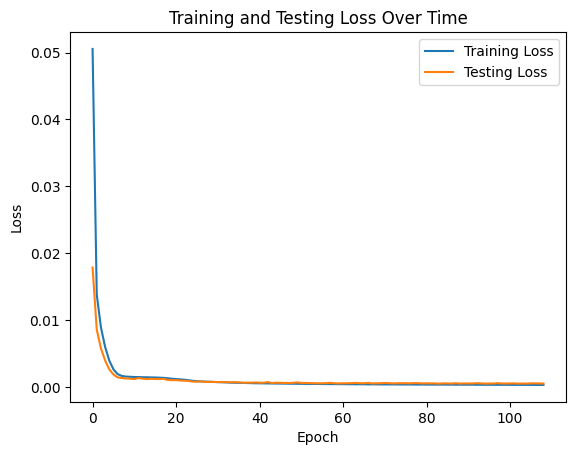

In [ ]:
# Set the input sequence length to one week (168 hours)
input_seq_len = 24*7 # time steps
output = 1  # predict one time step into the future

# Initialize the modek
model = Model(input_size=1, output_size=output, hidden_dim=128, n_layers=4) 
model = model.to(device)  # Move the model to the specified device (CPU or GPU)

# Set the number of training epochs and learning rate
num_epochs = 1000
learning_rate = 0.00001

# Process data
file_path = "data/bilan-electrique.csv"
train_loader, test_loader, scaler = preprocess_data(file_path, sequence_length=input_seq_len, output_seq_len=output, batch_size=32)

# Train the model
model = train_model(model, train_loader, test_loader, num_epochs, learning_rate)

In [ ]:
#save model to file
torch.save(model.state_dict(), 'model/model_{}.pth'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

# Show the prediction of our model

In [ ]:
def forecast(model: torch.nn.Module , df: pd.DataFrame , sequence_length : int , scaler , to_predict : int, device: torch.device) -> Tuple[List[float], List[float], List[str]]:
    """Forecast the next to_predict of consumption using the trained model and the last week of data.
    It is assumed that the model was trained with the same sequence_length.
    The predictions are done in a rolling manner, i.e. the first prediction is done using the last week of data, the second using the last week + the first prediction, etc.

    Args:
        model (torch.nn.Module): The trained model
        df (pandas.DataFrame): The dataframe containing the data
        sequence_length (int): The length of the input sequence used to predict the next value
        scaler (sklearn.preprocessing.MinMaxScaler): The scaler used to scale the data
        to_predict (int): The number of hours to predict
        device (torch.device): The device (CPU or GPU) to use for computation
    
    Returns:
        predicted (list): The predicted values
        real (list): The real values to predict
        horodate (list): The horodate values for the predicted and real values
    """
    
    # Extract the last week data and scale it
    last_week = df['consommation_totale'].values[-(sequence_length+to_predict):].reshape(-1, 1)
    last_week_scaled = scaler.transform(last_week)
    model.eval()  # set the model to evaluation mode
    predicted = []  # list to store the predicted values
    real = []  # list to store the real values
    horodate = []  # list to store the horodate values
    first_seq = last_week_scaled[:-to_predict]
    sequence = first_seq
    with torch.no_grad():
        # Start predicting the next week consumption hour by hour
        for i in range(to_predict):  # 24 hours * 7 days = 168 hours
            sequence = torch.FloatTensor(sequence).to(device)  # get the last sequence_length values and move to the device
            sequence = sequence.unsqueeze(0)  # add a batch dimension
            prediction = model(sequence)  # make a prediction
            predicted_value = prediction[0, -1].item()  # get the last value (last hour prediction)
            predicted.append(scaler.inverse_transform([[predicted_value]]))  # reverse the scaling and append the prediction to the list
            
            # Append the real value to the list
            try:
                real_value = df['consommation_totale'].values[i-(to_predict)]
                real.append(real_value)
            except IndexError:  # if we've stepped out of the dataset boundaries (means we're predicting the future values)
                real.append(None)
            
            # Append the horodate value to the list
            horodate.append(df['horodate'].values[i-(to_predict)])
            
            # replace in sequence the first value with the predicted value
            sequence = sequence.squeeze(0).cpu()  # move the sequence back to CPU for numpy operations
            sequence = sequence[1:]
            sequence = torch.cat([sequence, torch.FloatTensor([[predicted_value]])], dim=0)
            
    # Flatten the predicted list to have 1D list
    predicted = [item[0][0] for item in predicted]
    
    return predicted, real, horodate


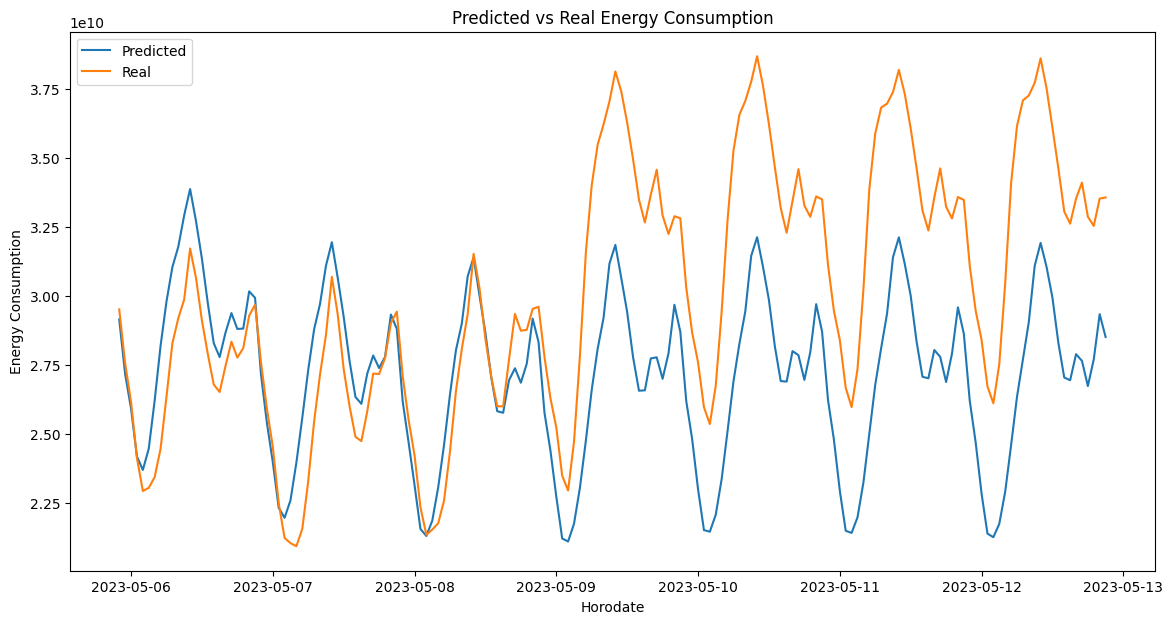

In [ ]:
time_to_predict = 24*7
df = read_data(file_path)
predicted, real, horodate = forecast(model, df, input_seq_len, scaler, to_predict = time_to_predict, device = device)
# Plot the predicted and real values
plt.figure(figsize=(14, 7))
plt.plot(horodate, predicted, label='Predicted')
plt.plot(horodate, real, label='Real')
plt.title('Predicted vs Real Energy Consumption')
plt.xlabel('Horodate')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()